In [130]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
import seaborn as sns
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import re

In [131]:
prices=pd.read_csv('stock_yfinance_data.csv') # read in stock data yfinance

In [132]:
type(prices['Date'][0])

str

In [133]:
prices['Date'] = pd.to_datetime(prices['Date']).dt.date.astype('datetime64[ns]')

In [134]:
type(prices['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [135]:
prices.head()

Date        Open        High         Low       Close   Adj Close  \
0 2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1 2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2 2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3 2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4 2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name  
0  53868000       TSLA  
1  51094200       TSLA  
2  91449900       TSLA  
3  55297800       TSLA  
4  43898400       TSLA

In [136]:
prices=prices.sort_values(by=['Date']).reset_index()
prices.head(15)
prices=prices.rename(columns={"Stock Name":"ticker_symbol","Date": "date", "Close":"close_value", "Volume":"volume", "Open":"open_value", "High":"high_value", "Low":"low_value"})

In [137]:
prices.head()

index       date  open_value  high_value   low_value  close_value  \
0      0 2021-09-30  260.333344  263.043335  258.333344   258.493347   
1    252 2021-09-30  285.709991  287.829987  281.619995   281.920013   
2   1008 2021-09-30  165.800003  166.392502  163.699493   164.251999   
3   5292 2021-09-30  150.190002  151.729996  148.000000   149.970001   
4   5796 2021-09-30  260.410004  263.519989  258.299988   262.220001   

    Adj Close    volume ticker_symbol  
0  258.493347  53868000          TSLA  
1  278.792847  32343600          MSFT  
2  164.251999  56848000          AMZN  
3  149.970001   1904500          ENPH  
4  262.220001   1355300            ZS

In [138]:
def create_indicators(data):
    
    prices = data.sort_values(by=['date']).reset_index()

    # create simple moving average
    n=[10,20,50,100]
    for i in n:
        prices.loc[:,(str("MA"+str(i)))]=prices['close_value'].rolling(i).mean()    

    # Calculate MACD  
    day26=prices['close_value'].ewm(span=26, adjust=False).mean()
    day12=prices['close_value'].ewm(span=12, adjust=False).mean()
    prices.loc[:,('macd')]=day12-day26 
    prices.loc[:,('signal')]=prices['macd'].ewm(span=9, adjust=False).mean()

    # Calculate RSI 
    up = np.log(prices.close_value).diff(1)
    down = np.log(prices.close_value).diff(1)

    up[up<0]=0
    down[down>0]=0

    # Calculate the EWMA
    roll_up = up.ewm(span=14).mean()
    roll_down = down.abs().ewm(span=14).mean()

    # Calculate the RSI based on EWMA
    RS1 = roll_up / roll_down
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))
    prices.loc[:,('rsi')]=RSI1

    return prices

# create dict, by ticker
d = dict(tuple(prices.groupby('ticker_symbol')))



In [139]:
print(d)

{'AAPL':       index       date  open_value  high_value   low_value  close_value  \
9      1764 2021-09-30  143.660004  144.380005  141.279999   141.500000   
45     1765 2021-10-01  141.899994  142.919998  139.110001   142.649994   
51     1766 2021-10-04  141.759995  142.210007  138.270004   139.139999   
93     1767 2021-10-05  139.490005  142.240005  139.360001   141.110001   
110    1768 2021-10-06  139.470001  142.149994  138.369995   142.000000   
...     ...        ...         ...         ...         ...          ...   
6177   2011 2022-09-23  151.190002  151.470001  148.559998   150.429993   
6219   2012 2022-09-26  149.660004  153.770004  149.639999   150.770004   
6227   2013 2022-09-27  152.740005  154.720001  149.949997   151.759995   
6259   2014 2022-09-28  147.639999  150.639999  144.839996   149.839996   
6298   2015 2022-09-29  146.100006  146.720001  140.679993   142.479996   

       Adj Close     volume ticker_symbol  
9     140.478485   89056700          AAPL  
45

In [141]:
d = {k:create_indicators(v) for k, v in d.items()}

In [142]:
d['TSLA'].head(150)

level_0  index       date  open_value  high_value   low_value  \
0          0      0 2021-09-30  260.333344  263.043335  258.333344   
1         43      1 2021-10-01  259.466675  260.260010  254.529999   
2         65      2 2021-10-04  265.500000  268.989990  258.706665   
3         89      3 2021-10-05  261.600006  265.769989  258.066681   
4        103      4 2021-10-06  258.733337  262.220001  257.739990   
..       ...    ...        ...         ...         ...         ...   
145     3644    145 2022-04-28  299.993347  300.000000  273.899994   
146     3651    146 2022-04-29  300.750000  311.466675  290.000000   
147     3682    147 2022-05-02  286.923340  302.119995  282.676666   
148     3705    148 2022-05-03  301.059998  308.026672  296.196655   
149     3748    149 2022-05-04  301.313324  318.500000  295.093323   

     close_value   Adj Close     volume ticker_symbol        MA10        MA20  \
0     258.493347  258.493347   53868000          TSLA         NaN         NaN   
1     258.406677  258.406677   51094200          TSLA         NaN         NaN   
2     260.510010  260.510010   91449900          TSLA         NaN         NaN   
3     260.196655  260.196655   55297800          TSLA         NaN         NaN   
4     260.916656  260.916656   43898400          TSLA         NaN         NaN   
..           ...         ...        ...           ...         ...         ...   
145   292.503326  292.503326  124948500          TSLA  321.397672  335.909837   
146   290.253326  290.253326   88133100          TSLA  317.589670  332.462503   
147   300.980011  300.980011   75781500          TSLA  314.211337  329.435004   
148   303.083344  303.083344   63709500          TSLA  310.248004  325.498337   
149   317.540009  317.540009   81643800          TSLA  309.428671  323.187671   

           MA50       MA100      macd    signal        rsi  
0           NaN         NaN  0.000000  0.000000        NaN  
1           NaN         NaN -0.006914 -0.001383   0.000000  
2           NaN         NaN  0.155535  0.030001  96.538981  
3           NaN         NaN  0.256041  0.075209  82.839117  
4           NaN         NaN  0.389303  0.138028  87.527896  
..          ...         ...       ...       ...        ...  
145  312.207200  320.769699 -5.175509  2.173456  27.250125  
146  311.856334  320.308866 -7.100039  0.318757  26.233919  
147  312.033600  319.812832 -7.671260 -1.279246  38.641632  
148  312.382067  319.280466 -7.863588 -2.596115  40.844805  
149  313.256001  319.109866 -6.771421 -3.431176  53.684173  

[150 rows x 17 columns]

In [143]:
# get subset of prices from start to end date
def subset_prices(d,ticker,start,end):
    x=d[ticker]
    x=x[((x.date>=start)&(x.date<=end))]
    return x

In [144]:
# from azure.ai.textanalytics import TextAnalyticsClient
# from azure.core.credentials import AzureKeyCredential



In [145]:
# credential = AzureKeyCredential("908ac542166e4abaa90153eb9648e2ee")
# client = TextAnalyticsClient(endpoint="https://text-sent-720.cognitiveservices.azure.com/", credential=credential)

In [146]:
# sentence = 'Room was clean, but staff was rude.'

# res = client.analyze_sentiment(documents=[sentence])

In [147]:
# print('Scores : {}'.format(res[0]))

In [148]:
# client.close()

In [149]:
tweets = pd.read_csv('stock_tweets.csv')

In [150]:
tweets['date'] = pd.to_datetime(tweets['Date']).dt.date.astype('datetime64[ns]')

In [151]:
tweets['time'] = pd.to_datetime(tweets['Date'])

In [152]:
tweets['time'] = tweets['time'].dt.time

In [153]:
tweets['Date'] = pd.to_datetime(tweets['Date'])

In [154]:
type(tweets['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [155]:
tweets.tail()

Date  \
80788 2021-10-07 17:11:57+00:00   
80789 2021-10-04 17:05:59+00:00   
80790 2021-10-01 04:43:41+00:00   
80791 2021-10-01 00:03:32+00:00   
80792 2021-09-30 10:22:52+00:00   

                                                   Tweet Stock Name  \
80788  Some of the fastest growing tech stocks on the...       XPEV   
80789  With earnings on the horizon, here is a quick ...       XPEV   
80790  Our record delivery results are a testimony of...       XPEV   
80791  We delivered 10,412 Smart EVs in Sep 2021, rea...       XPEV   
80792  Why can XPeng P5 deliver outstanding performan...       XPEV   

      Company Name       date      time  
80788   XPeng Inc. 2021-10-07  17:11:57  
80789   XPeng Inc. 2021-10-04  17:05:59  
80790   XPeng Inc. 2021-10-01  04:43:41  
80791   XPeng Inc. 2021-10-01  00:03:32  
80792   XPeng Inc. 2021-09-30  10:22:52

In [156]:
merged_df = pd.merge(tweets[tweets['Stock Name']=='TSLA'], d['TSLA'], on=['date'], how='outer')

In [157]:
merged_df.head()

Date  \
0 2022-09-29 23:41:16+00:00   
1 2022-09-29 23:24:43+00:00   
2 2022-09-29 23:18:08+00:00   
3 2022-09-29 22:40:07+00:00   
4 2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  \
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.   
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.   
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.   
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.   
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.   

        date      time  level_0  index  open_value  high_value  ...  \
0 2022-09-29  23:41:16   6297.0  251.0   282.76001  283.649994  ...   
1 2022-09-29  23:24:43   6297.0  251.0   282.76001  283.649994  ...   
2 2022-09-29  23:18:08   6297.0  251.0   282.76001  283.649994  ...   
3 2022-09-29  22:40:07   6297.0  251.0   282.76001  283.649994  ...   
4 2022-09-29  22:27:05   6297.0  251.0   282.76001  283.649994  ...   

    Adj Close      volume  ticker_symbol     MA10        MA20        MA50  \
0  268.209991  77620600.0           TSLA  290.084  289.909001  290.086001   
1  268.209991  77620600.0           TSLA  290.084  289.909001  290.086001   
2  268.209991  77620600.0           TSLA  290.084  289.909001  290.086001   
3  268.209991  77620600.0           TSLA  290.084  289.909001  290.086001   
4  268.209991  77620600.0           TSLA  290.084  289.909001  290.086001   

        MA100      macd    signal        rsi  
0  263.810667 -1.896618  1.307454  31.446752  
1  263.810667 -1.896618  1.307454  31.446752  
2  263.810667 -1.896618  1.307454  31.446752  
3  263.810667 -1.896618  1.307454  31.446752  
4  263.810667 -1.896618  1.307454  31.446752  

[5 rows x 22 columns]

In [158]:
grouped_df = merged_df.groupby('date').agg({'Tweet': 'count', 'volume': 'mean'})

In [159]:
grouped_df.head()

Tweet      volume
date                         
2021-09-30     90  53868000.0
2021-10-01     94  51094200.0
2021-10-02    116         NaN
2021-10-03     61         NaN
2021-10-04    119  91449900.0

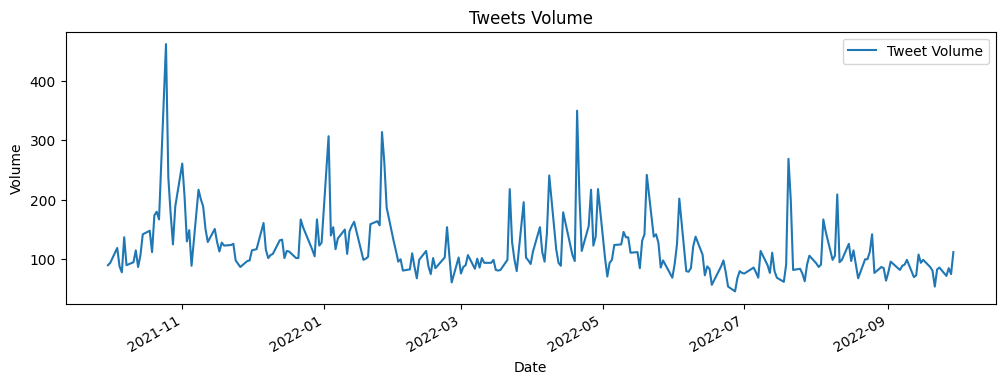

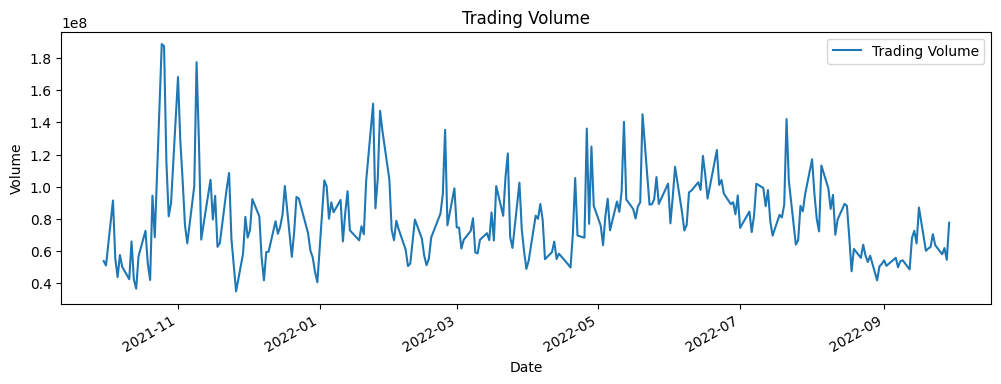

In [240]:

grouped_df.dropna().plot(y='Tweet', label='Tweet Volume',figsize=(12, 4))
plt.title('Tweets Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
grouped_df.dropna().plot(y='volume', label='Trading Volume',figsize=(12, 4))

plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Trading Volume')
plt.legend()
plt.show()


In [187]:
grouped_df.dropna().corr()

Tweet    volume
Tweet   1.000000  0.513868
volume  0.513868  1.000000

In [161]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [348]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [349]:
example = "Mainstream media has done an amazing job at brainwashing people. Today at work, we were asked what companies we believe in  and  I said @Tesla because they make the safest cars  and  EVERYONE disagreed with me because they heardâ€œthey catch on fire  and  the batteries cost 20k to replaceâ€"


In [350]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
print(output)
scores = output[0][0].detach().numpy()
print(scores)
import torch.nn.functional as F
probs = F.softmax(output.logits, dim=-1)
probs[0][0]=0.0
probs[0][1]=0.792
probs[0][2]=0.208
print(probs)
weights = torch.tensor([1, 0, -1])  # positive, neutral, negative
score = (probs * weights).sum().item()
print(score,"&&&&&&")

print(scores)
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)


SequenceClassifierOutput(loss=None, logits=tensor([[ 0.7839,  0.1588, -0.9870]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
[ 0.7838984   0.1588272  -0.98702323]
tensor([[0.0000, 0.7920, 0.2080]], grad_fn=<CopySlices>)
-0.20800000429153442 &&&&&&
[ 0.7838984   0.1588272  -0.98702323]
{'roberta_neg': 0.586373, 'roberta_neu': 0.31384048, 'roberta_pos': 0.09978664}


In [165]:
def Preprocess_Tweets(data):
		
	data['Text_Cleaned'] = data['Tweet']

	## FIX HYPERLINKS
	data['Text_Cleaned'] = data['Text_Cleaned'].replace(r'https?:\/\/.*[\r\n]*', ' ',regex=True)
	data['Text_Cleaned'] = data['Text_Cleaned'].replace(r'www.*[\r\n]*', ' ',regex=True)
	data['Text_Cleaned'] = data['Text_Cleaned'].str.replace('https', '', regex=False)


	## FIX EMOJIS
	data['Text_Cleaned'] = data['Text_Cleaned'].str.replace(':)', '', regex=False)
	data['Text_Cleaned'] = data['Text_Cleaned'].str.replace(':-)', '', regex=False)
	data['Text_Cleaned'] = data['Text_Cleaned'].str.replace(':(', '', regex=False)
	data['Text_Cleaned'] = data['Text_Cleaned'].str.replace(':-(', '', regex=False)
	data['Text_Cleaned'] = data['Text_Cleaned'].str.replace('0_o', '', regex=False)
	data['Text_Cleaned'] = data['Text_Cleaned'].str.replace(';)', '', regex=False)
	data['Text_Cleaned'] = data['Text_Cleaned'].str.replace('=^.^=', '', regex=False)
	data['Text_Cleaned'] = data['Text_Cleaned'].str.replace(':-D', '', regex=False)
	data['Text_Cleaned'] = data['Text_Cleaned'].str.replace(':D', '', regex=False)
 
	## Other
	data['Text_Cleaned'] = data['Text_Cleaned'].str.replace('&amp;', ' and ', regex=False)
	
	   
		


	return data

In [166]:
Preprocess_Tweets(merged_df)
merged_df.head()

Date  \
0 2022-09-29 23:41:16+00:00   
1 2022-09-29 23:24:43+00:00   
2 2022-09-29 23:18:08+00:00   
3 2022-09-29 22:40:07+00:00   
4 2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  \
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.   
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.   
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.   
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.   
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.   

        date      time  level_0  index  open_value  high_value  ...  \
0 2022-09-29  23:41:16   6297.0  251.0   282.76001  283.649994  ...   
1 2022-09-29  23:24:43   6297.0  251.0   282.76001  283.649994  ...   
2 2022-09-29  23:18:08   6297.0  251.0   282.76001  283.649994  ...   
3 2022-09-29  22:40:07   6297.0  251.0   282.76001  283.649994  ...   
4 2022-09-29  22:27:05   6297.0  251.0   282.76001  283.649994  ...   

       volume  ticker_symbol     MA10        MA20        MA50       MA100  \
0  77620600.0           TSLA  290.084  289.909001  290.086001  263.810667   
1  77620600.0           TSLA  290.084  289.909001  290.086001  263.810667   
2  77620600.0           TSLA  290.084  289.909001  290.086001  263.810667   
3  77620600.0           TSLA  290.084  289.909001  290.086001  263.810667   
4  77620600.0           TSLA  290.084  289.909001  290.086001  263.810667   

       macd    signal        rsi  \
0 -1.896618  1.307454  31.446752   
1 -1.896618  1.307454  31.446752   
2 -1.896618  1.307454  31.446752   
3 -1.896618  1.307454  31.446752   
4 -1.896618  1.307454  31.446752   

                                        Text_Cleaned  
0  Mainstream media has done an amazing job at br...  
1  Tesla delivery estimates are at around 364k fr...  
2  3/ Even if I include 63.0M unvested RSUs as of...  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...  
4  @RealDanODowd @Tesla Stop trying to kill kids,...  

[5 rows x 23 columns]

In [167]:
merged_df.to_csv('cleaned_tweets.csv', index=False)

In [168]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [169]:
sentiment_scores = merged_df['Text_Cleaned'].apply(polarity_scores_roberta)

In [170]:
# Create new columns for the sentiment scores
merged_df['positive'] = sentiment_scores.apply(lambda x: x['roberta_pos'])
merged_df['negative'] = sentiment_scores.apply(lambda x: x['roberta_neg'])
merged_df['neutral'] = sentiment_scores.apply(lambda x: x['roberta_neu'])

In [171]:
merged_df.to_csv('cleaned_tweets_with_scores.csv', index=False)

In [232]:
merged_df.head()

Date  \
0 2022-09-29 23:41:16+00:00   
1 2022-09-29 23:24:43+00:00   
2 2022-09-29 23:18:08+00:00   
3 2022-09-29 22:40:07+00:00   
4 2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  \
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.   
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.   
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.   
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.   
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.   

        date      time  level_0  index  open_value  high_value  ...  \
0 2022-09-29  23:41:16   6297.0  251.0   282.76001  283.649994  ...   
1 2022-09-29  23:24:43   6297.0  251.0   282.76001  283.649994  ...   
2 2022-09-29  23:18:08   6297.0  251.0   282.76001  283.649994  ...   
3 2022-09-29  22:40:07   6297.0  251.0   282.76001  283.649994  ...   
4 2022-09-29  22:27:05   6297.0  251.0   282.76001  283.649994  ...   

         MA20        MA50       MA100      macd    signal        rsi  \
0  289.909001  290.086001  263.810667 -1.896618  1.307454  31.446752   
1  289.909001  290.086001  263.810667 -1.896618  1.307454  31.446752   
2  289.909001  290.086001  263.810667 -1.896618  1.307454  31.446752   
3  289.909001  290.086001  263.810667 -1.896618  1.307454  31.446752   
4  289.909001  290.086001  263.810667 -1.896618  1.307454  31.446752   

                                        Text_Cleaned  positive  negative  \
0  Mainstream media has done an amazing job at br...  0.103786  0.562671   
1  Tesla delivery estimates are at around 364k fr...  0.267919  0.012934   
2  3/ Even if I include 63.0M unvested RSUs as of...  0.062938  0.098909   
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...  0.010838  0.913476   
4  @RealDanODowd @Tesla Stop trying to kill kids,...  0.002161  0.971596   

    neutral  
0  0.333543  
1  0.719146  
2  0.838153  
3  0.075686  
4  0.026244  

[5 rows x 26 columns]

<AxesSubplot: xlabel='date', ylabel='score'>

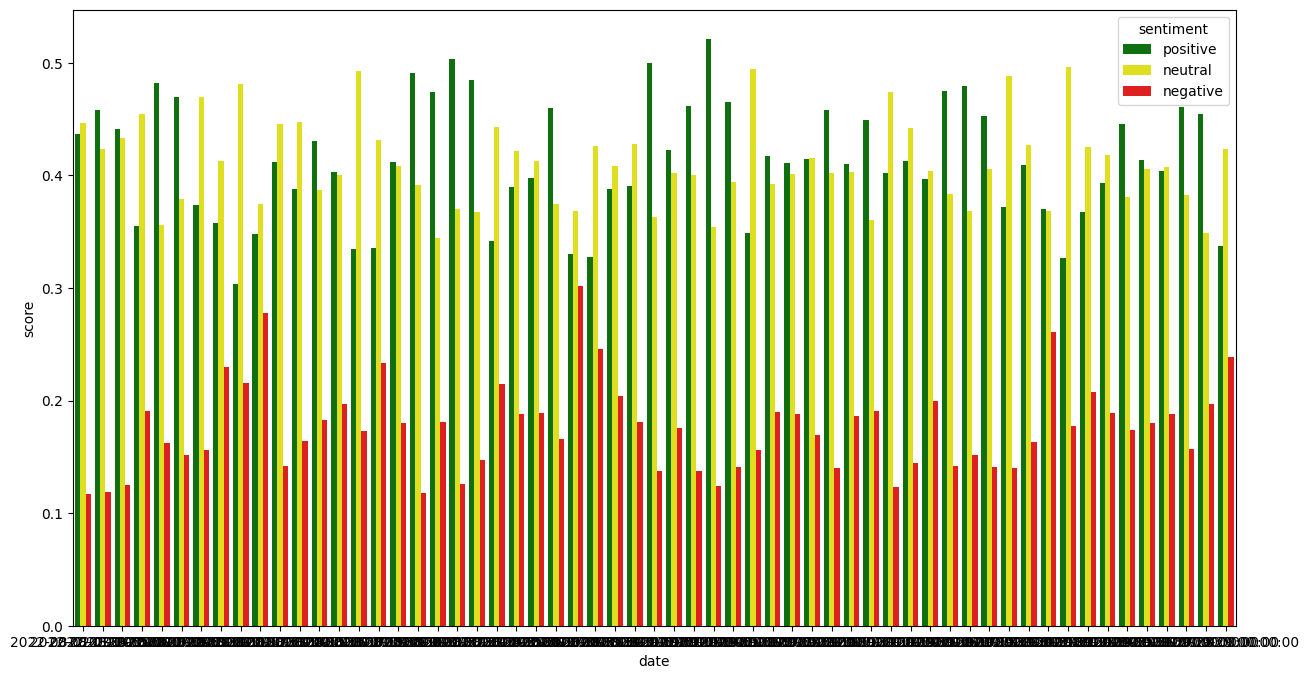

In [241]:
# Group the DataFrame by date and calculate mean sentiment scores
grouped_data = merged_df[merged_df['date'] > pd.to_datetime('2022-08-01')].groupby('date')[['positive', 'neutral', 'negative']].mean()

grouped_data = grouped_data.div(grouped_data.sum(axis=1), axis=0)
# Reshape the DataFrame using the melt() method
melted_data = grouped_data.melt(var_name='sentiment', value_name='score', ignore_index=False)
colors = {'positive': 'green', 'neutral': 'yellow', 'negative': 'red'}
# Create the stacked barplot using Seaborn
plt.figure(figsize=(15, 8))
sns.barplot(x=melted_data.index, y='score', hue='sentiment', data=melted_data, palette=colors, orient='v')
plt.xticks()

Text(0, 0.5, 'Price')

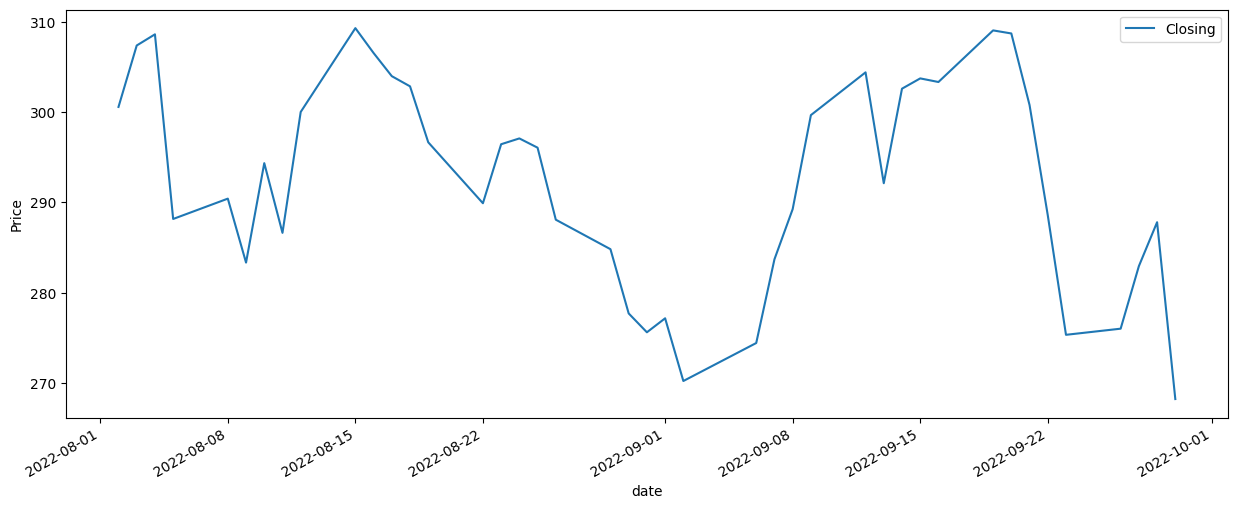

In [268]:
tsl = d['TSLA']
tsl[tsl['date'] > pd.to_datetime('2022-08-01')].plot(x = 'date',y='close_value', label='Closing',figsize=(15, 6))
plt.ylabel('Price')

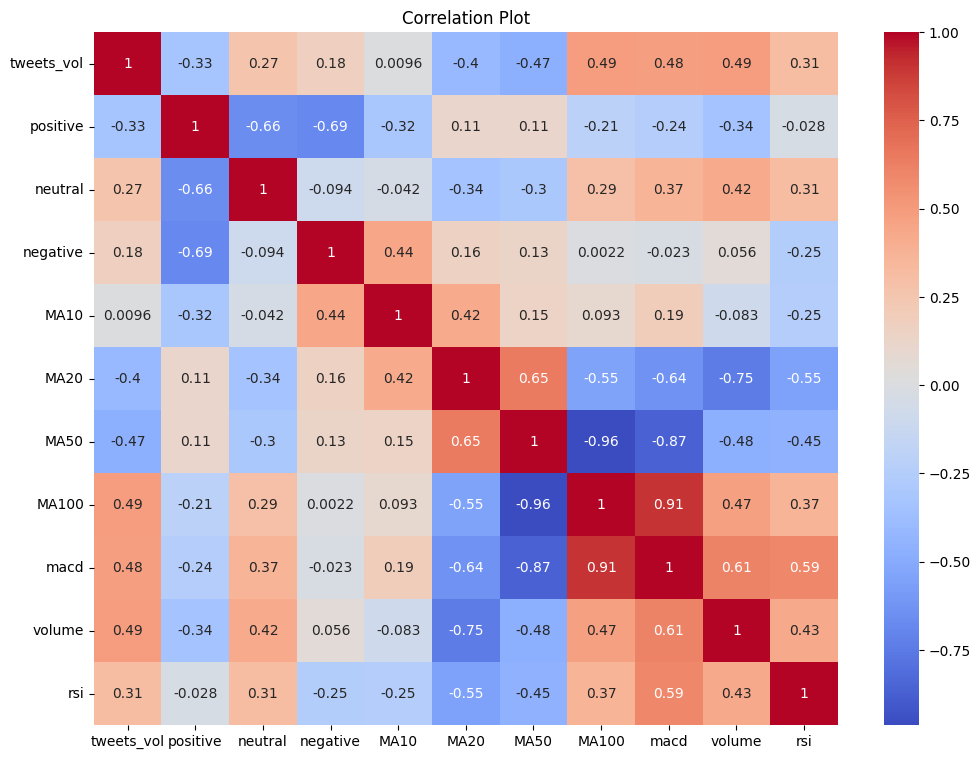

In [280]:
groups = merged_df[merged_df['date'] > pd.to_datetime('2022-08-01')].groupby('date').agg({'Text_Cleaned': 'count', 'volume': 'mean', 'positive': 'mean', 'neutral': 'mean', 'negative': 'mean', 'MA10': 'mean', 'MA20': 'mean', 'MA50': 'mean', 'MA100': 'mean', 'macd': 'mean','rsi': 'mean'})
cols_to_plot = ['tweets_vol','positive', 'neutral', 'negative', 'MA10', 'MA20', 'MA50', 'MA100', 'macd', 'volume','rsi']
groups.rename(columns={'Text_Cleaned': 'tweets_vol'}, inplace=True)
corr_matrix = groups[cols_to_plot].corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Plot')
plt.show()

In [330]:
df_argmax = merged_df

Date  \
0 2022-09-29 23:41:16+00:00   
1 2022-09-29 23:24:43+00:00   
2 2022-09-29 23:18:08+00:00   
3 2022-09-29 22:40:07+00:00   
4 2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  \
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.   
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.   
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.   
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.   
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.   

        date      time  level_0  index  open_value  high_value  ...  \
0 2022-09-29  23:41:16   6297.0  251.0   282.76001  283.649994  ...   
1 2022-09-29  23:24:43   6297.0  251.0   282.76001  283.649994  ...   
2 2022-09-29  23:18:08   6297.0  251.0   282.76001  283.649994  ...   
3 2022-09-29  22:40:07   6297.0  251.0   282.76001  283.649994  ...   
4 2022-09-29  22:27:05   6297.0  251.0   282.76001  283.649994  ...   

         MA20        MA50       MA100      macd    signal        rsi  \
0  289.909001  290.086001  263.810667 -1.896618  1.307454  31.446752   
1  289.909001  290.086001  263.810667 -1.896618  1.307454  31.446752   
2  289.909001  290.086001  263.810667 -1.896618  1.307454  31.446752   
3  289.909001  290.086001  263.810667 -1.896618  1.307454  31.446752   
4  289.909001  290.086001  263.810667 -1.896618  1.307454  31.446752   

                                        Text_Cleaned  positive  negative  \
0  Mainstream media has done an amazing job at br...  0.103786  0.562671   
1  Tesla delivery estimates are at around 364k fr...  0.267919  0.012934   
2  3/ Even if I include 63.0M unvested RSUs as of...  0.062938  0.098909   
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...  0.010838  0.913476   
4  @RealDanODowd @Tesla Stop trying to kill kids,...  0.002161  0.971596   

    neutral  
0  0.333543  
1  0.719146  
2  0.838153  
3  0.075686  
4  0.026244  

[5 rows x 26 columns]

In [331]:
grouped_df.head()

Tweet      volume
date                         
2021-09-30     90  53868000.0
2021-10-01     94  51094200.0
2021-10-02    116         NaN
2021-10-03     61         NaN
2021-10-04    119  91449900.0

In [332]:
# Importing Wordcloud for visualization
from wordcloud import WordCloud
# Importing stopwords to remove those english word which will not add any value to our model
from nltk.corpus import stopwords

In [336]:
text_neg = " ".join(merged_df[merged_df['negative'] > 0.7]['Text_Cleaned'].tolist())

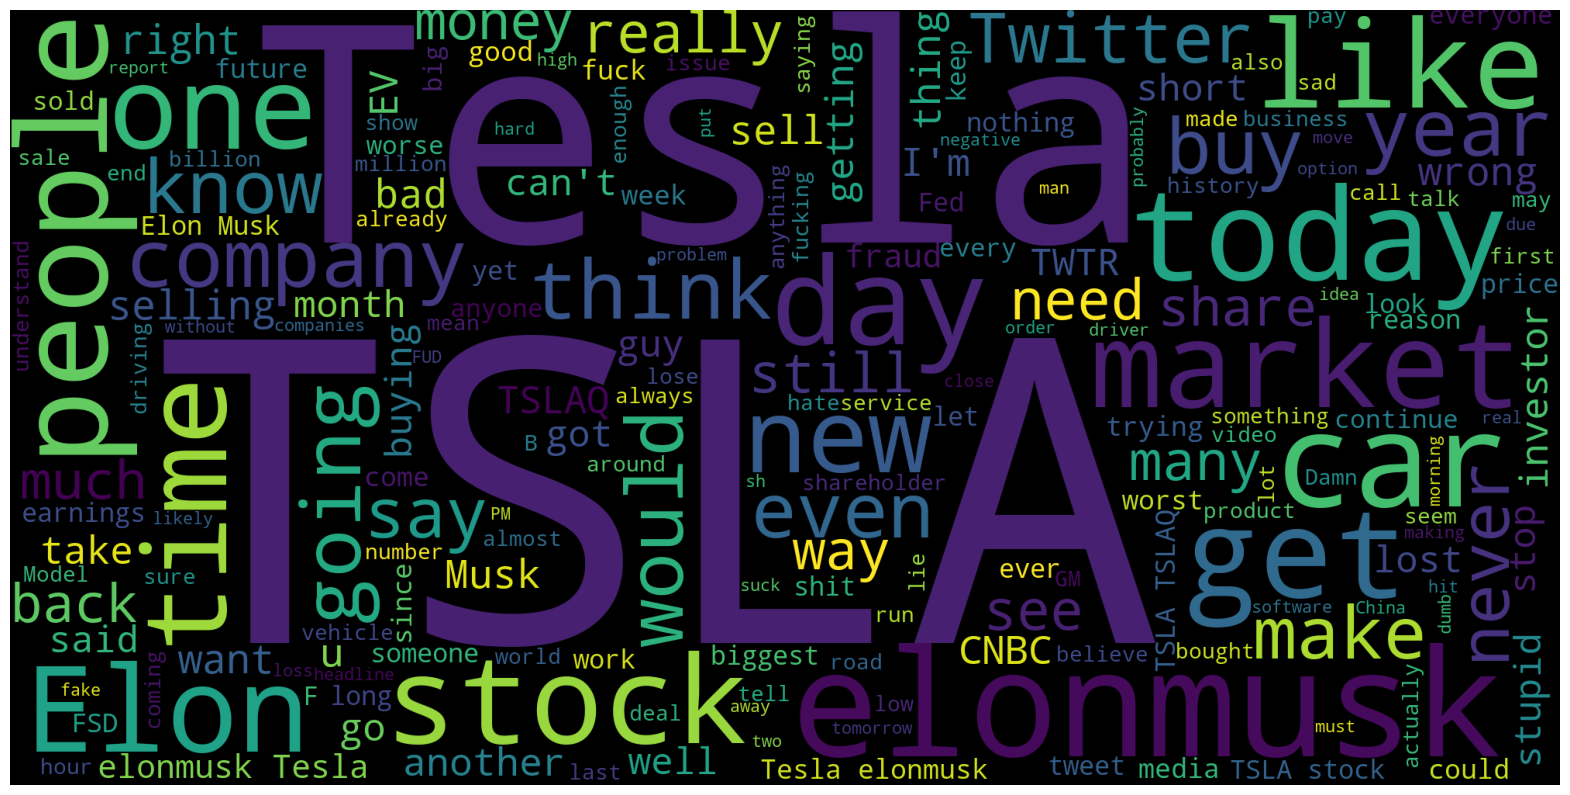

In [340]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=42, background_color='black', collocations=True, stopwords = stopwords.words('english')).generate(text_neg)
plt.figure(figsize=(20, 30))
# Display image
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

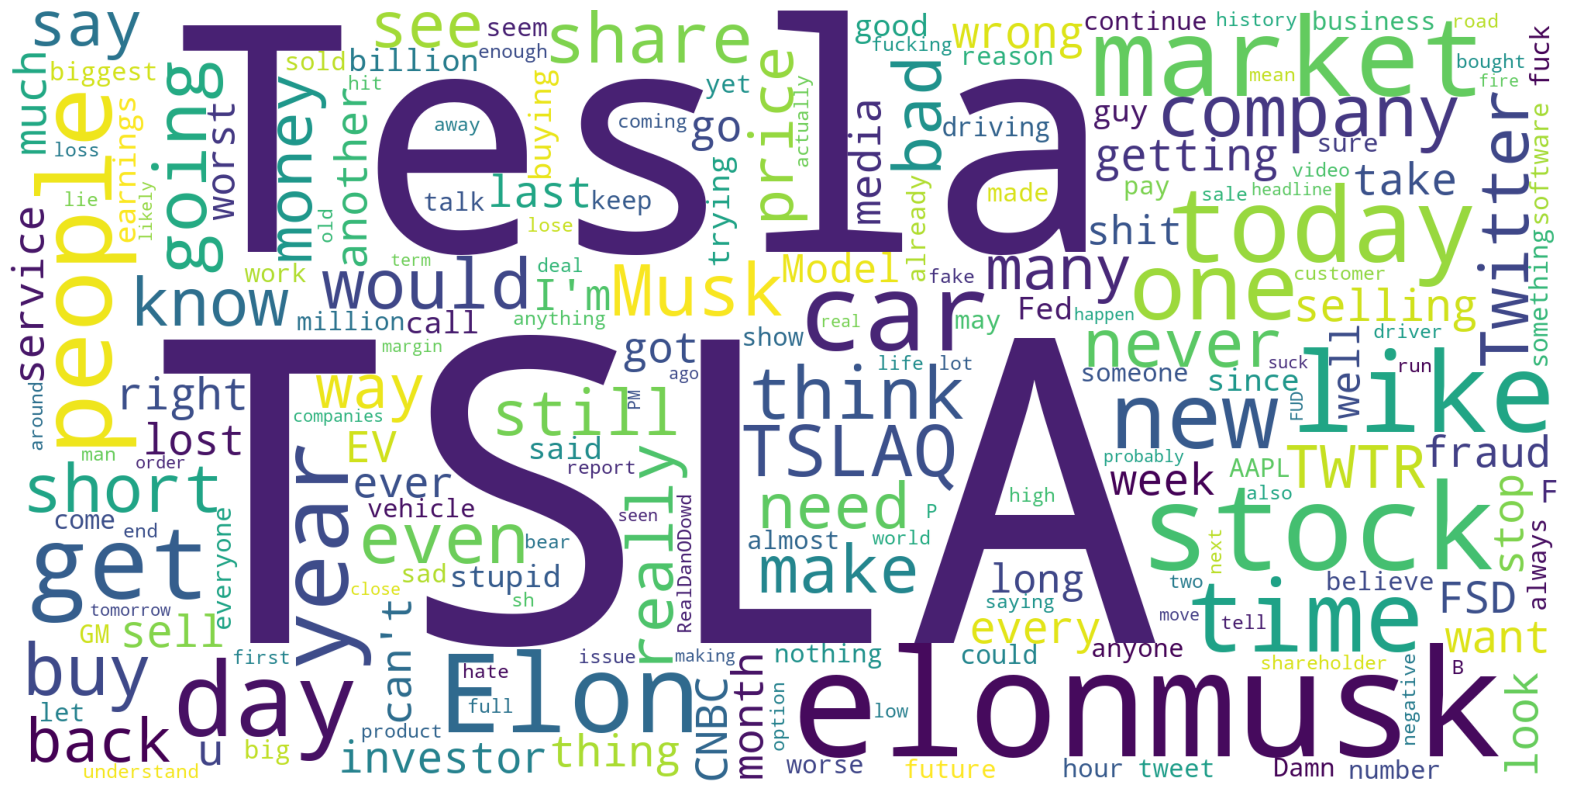

In [344]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=42, background_color='white', collocations=False, stopwords = stopwords.words('english')).generate(text_neg)
plt.figure(figsize=(20, 30))
# Display image
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

In [ ]:
text_pos = " ".join(merged_df[merged_df['positive'] > 0.7]['Text_Cleaned'].tolist())

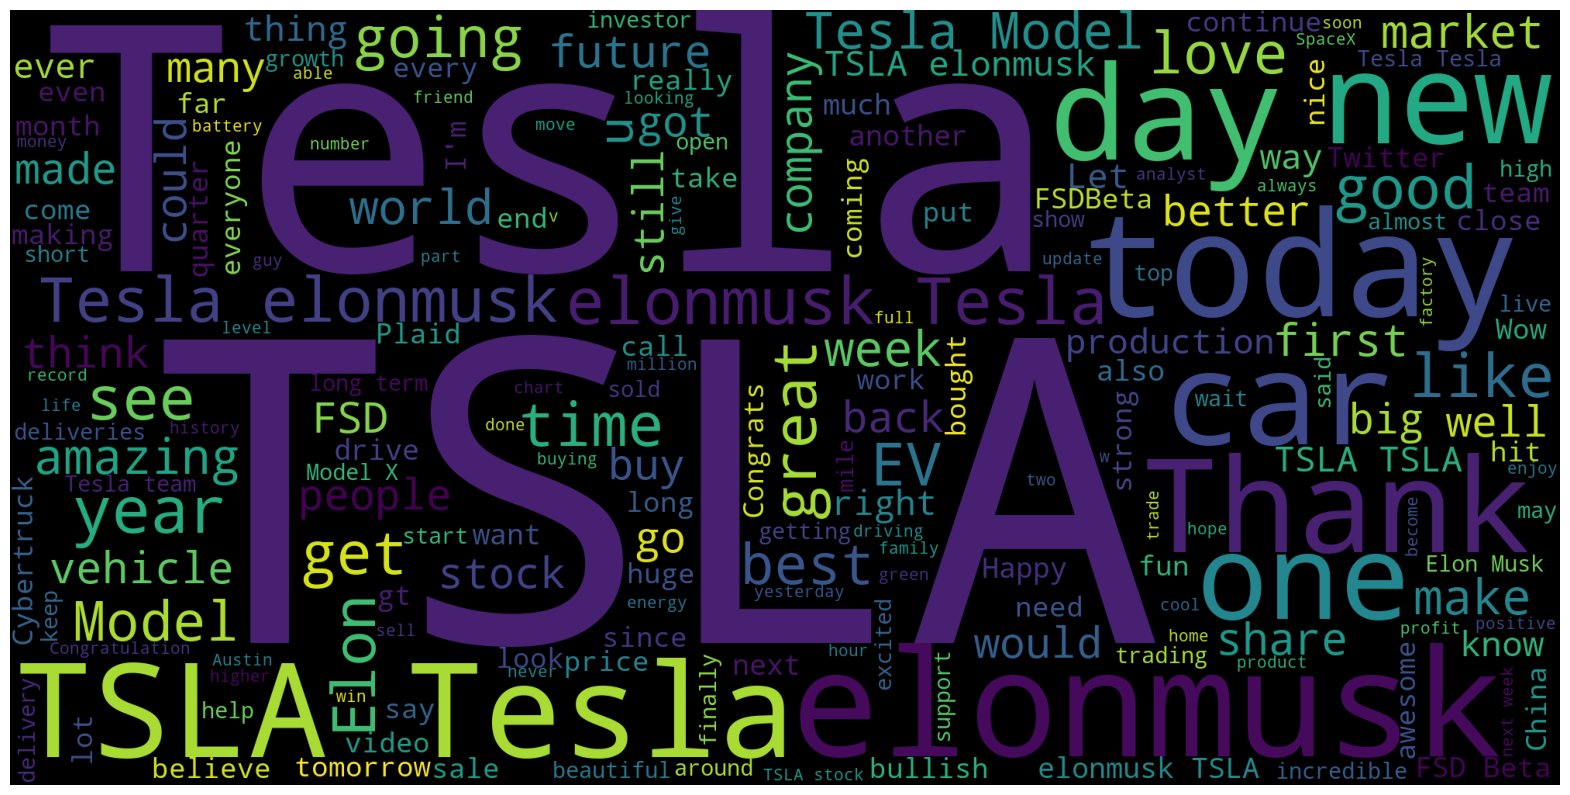

In [343]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=42, background_color='black', collocations=True, stopwords = stopwords.words('english')).generate(text_pos)
plt.figure(figsize=(20, 30))
# Display image
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

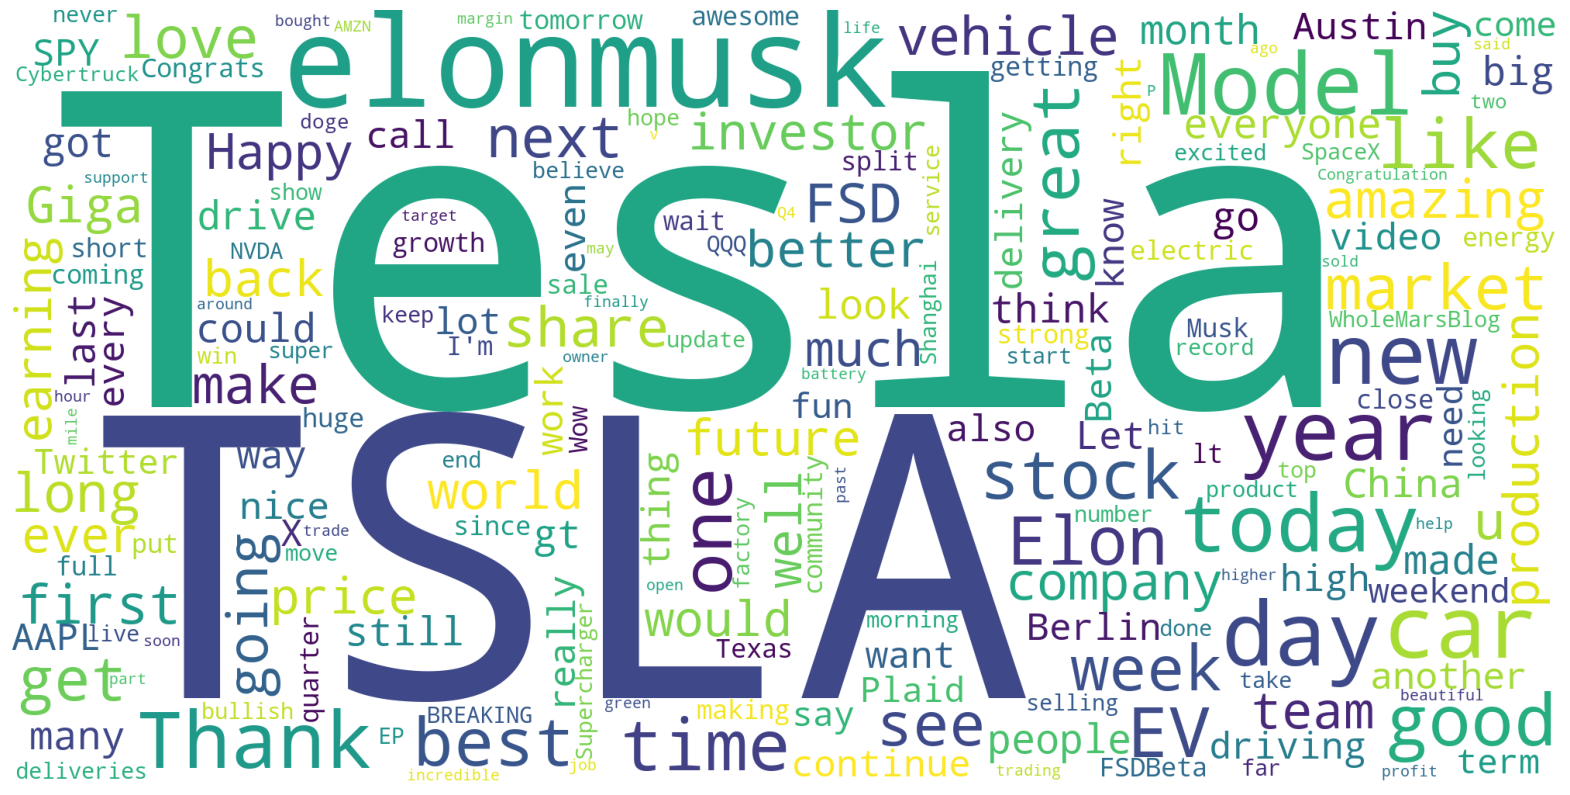

In [345]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=42, background_color='white', collocations=False, stopwords = stopwords.words('english')).generate(text_pos)
plt.figure(figsize=(20, 30))
# Display image
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

In [352]:
text_pos_1 = " ".join(merged_df[merged_df['positive'] > 0.5]['Text_Cleaned'].tolist())

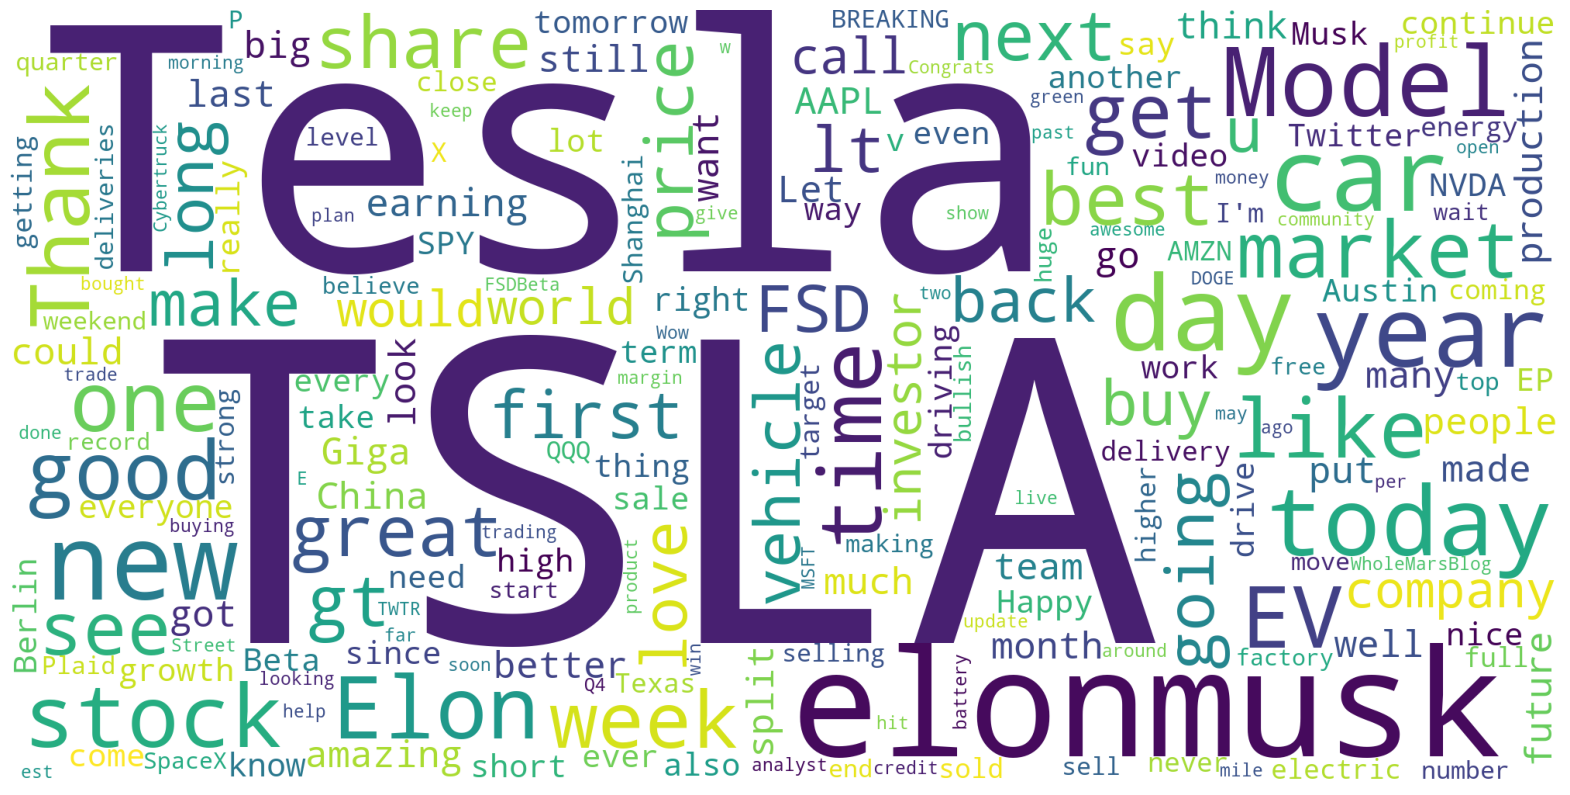

In [353]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=42, background_color='white', collocations=False, stopwords = stopwords.words('english')).generate(text_pos_1)
plt.figure(figsize=(20, 30))
# Display image
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()

In [354]:
text_neg_1 = " ".join(merged_df[merged_df['negative'] > 0.5]['Text_Cleaned'].tolist())

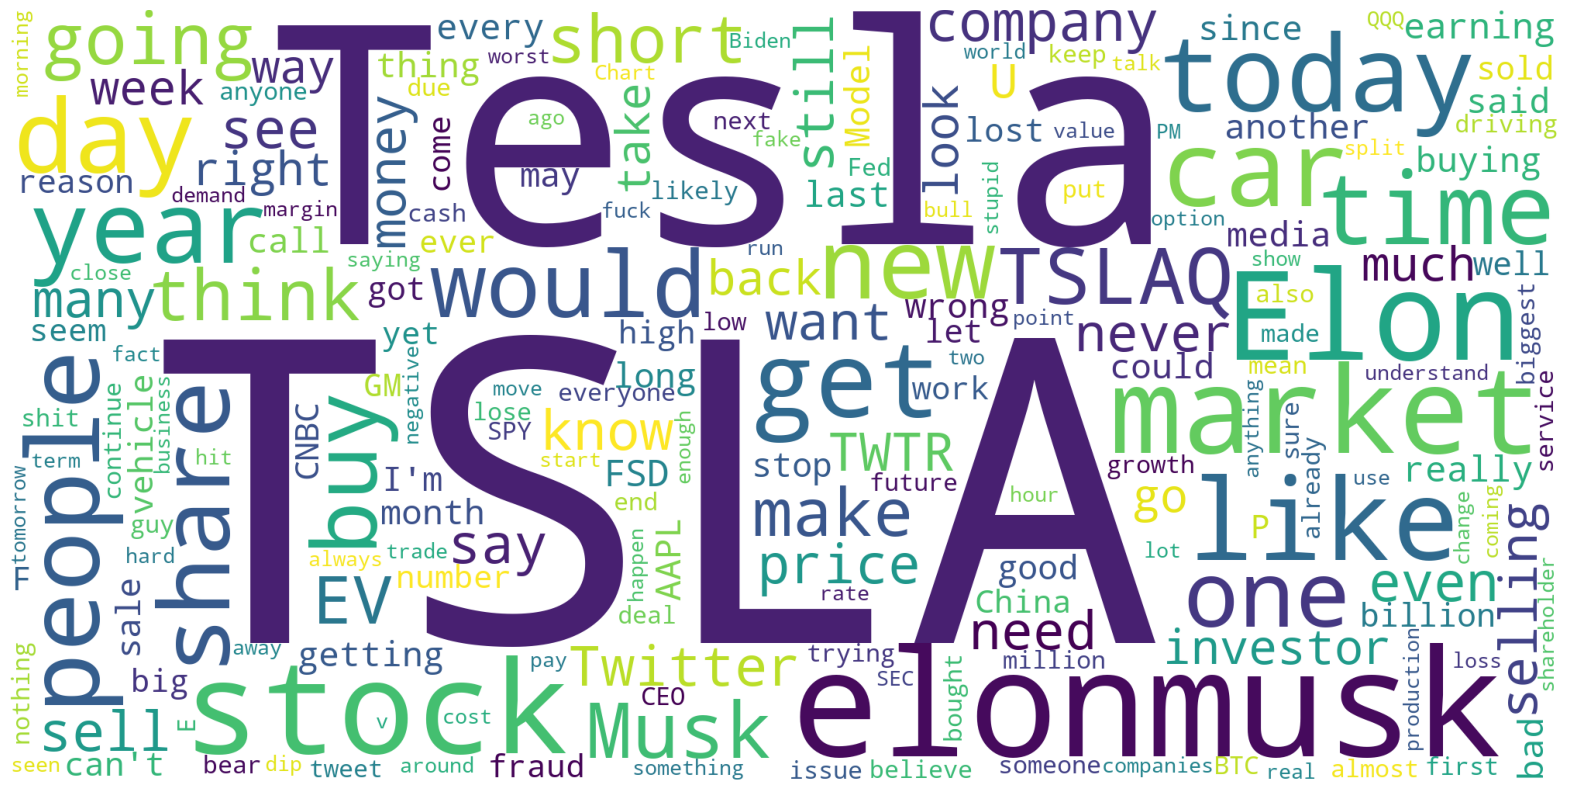

In [355]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=42, background_color='white', collocations=False, stopwords = stopwords.words('english')).generate(text_neg_1)
plt.figure(figsize=(20, 30))
# Display image
plt.imshow(wordcloud) 
plt.axis("off")
plt.show()